In [1]:
# import cv2
from scipy.ndimage.interpolation    import map_coordinates
# Array and image processing toolboxes
import numpy as np 
import skimage
import skimage.io
import skimage.transform
import skimage.segmentation
from skimage import io
from scipy.ndimage.filters import gaussian_filter as gaussian
import time
from scipy.ndimage.morphology import binary_erosion
from skimage.segmentation import find_boundaries
from random import shuffle
from natsort import natsorted
import os, sys, glob, time
from skimage.filters import sobel
from skimage.measure import label
import matplotlib.pyplot as plt
import colorsys

In [2]:
def get_cell_prob (lbl, dilation, erosion):
    ESP = 1e-5
    elevation_map = []
    for img in lbl:
        elevation_map += [sobel (img)]
    elevation_map = np.array (elevation_map)
    elevation_map = elevation_map > ESP
    cell_prob = ((lbl > 0) ^ elevation_map) & (lbl > 0)
    for i in range (len (cell_prob)):
        for j in range (erosion):
            cell_prob [i] = binary_erosion (cell_prob [i])
    for i in range (len (cell_prob)):
        for j in range (dilation):
            cell_prob [i] = binary_dilation (cell_prob [i])
    return np.array (cell_prob, dtype=np.uint8) * 255

def get_data (path):
    train_path = natsorted (glob.glob(path + 'A/*.tif'))
    train_label_path = natsorted (glob.glob(path + 'B/*.tif'))
    X_train = read_im (train_path)
    y_train = read_im (train_label_path)

    if (len (X_train) > 0):
        X_train = X_train [0]
    if (len (y_train) > 0):
        y_train = y_train [0]
        gt_prob = get_cell_prob (y_train, 0, 0)
        y_train = []
        for img in gt_prob:
            y_train += [label (img).astype (np.int32)]
        y_train = np.array (y_train)
    else:
        y_train = np.zeros_like (X_train)
    return X_train, y_train

def setup_data ():
    raw , gt_lbl = get_data (path='../Data/train/')
    raw = raw 
    gt_lbl = gt_lbl
    return raw, gt_lbl

def read_im (paths):
    ret = []
    for path in paths:
        ret.append (io.imread (path))
    return ret

In [3]:
raw , gt_lbl = setup_data ()

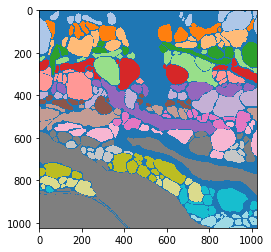

In [4]:
plt.imshow (gt_lbl [0], cmap='tab20')
plt.show ()

In [5]:
from scipy import ndimage as ndi

distance = ndi.distance_transform_edt(gt_lbl [0][100:260,100:260])


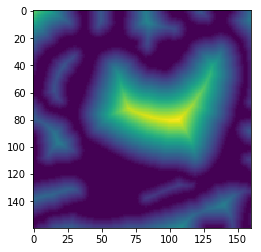

38.01315561749642
0.0


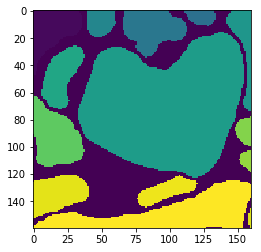

In [6]:
plt.imshow (distance)
plt.show ()
tmp_lbl = gt_lbl [0][100:260,100:260]
print (np.max (distance))
print (np.min (distance))
plt.imshow (gt_lbl [0][100:260,100:260])
plt.show ()
tmp = gt_lbl [0][100:260,100:260]
# norm_dist = distance / np.max (distance)
# norm_dist = np.clip (norm_dist, 0.2, 1.0)
# plt.imshow (norm_dist)
# plt.show ()

In [7]:
print (np.mean (distance), np.max (distance), np.mean (distance) / np.max (distance))

7.538304663099869 38.01315561749642 0.1983077842564113


In [8]:
np.unique (tmp_lbl)

array([ 0,  2, 28, 30, 35, 40, 42, 45, 57, 62, 64, 72, 73, 74, 76],
      dtype=int32)

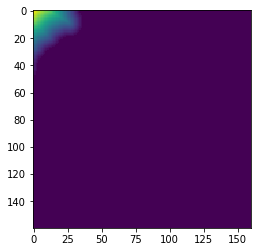

In [9]:
plt.imshow (distance * (tmp_lbl == 2))
plt.show ()

In [15]:
print (np.max (distance))

38.01315561749642


[0, 2, 28, 30, 35, 40, 42, 45, 57, 62, 64, 72, 73, 74, 76]


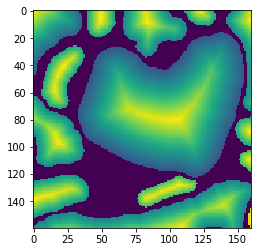

1.0 3.0


In [28]:
def density_map (lbl):
    distance = ndi.distance_transform_edt(lbl)
    idx_list = np.unique (lbl)
    distance = distance + 1.5 * np.std (distance)
    
    max_dist = np.max (distance)
    local_peak_dist_list = []
    ret = np.zeros (lbl.shape, dtype=np.float32)
    print (idx_list.tolist ())
    for i in idx_list:
        if i == 0:
            continue
        local_dist_map = distance * (lbl == i)
        local_peak_dist = np.max (local_dist_map)
        local_peak_dist_list.append (local_peak_dist)
        ret += local_dist_map * (max_dist / local_peak_dist)
    ret = ret / np.max (ret)
    ret = ret * 2 + 1
#     ret = np.clip (ret, 0.5, 3.0)
    return ret

processed_map = density_map (tmp_lbl)
plt.imshow (processed_map)
plt.show ()
print (np.min (processed_map), np.max (processed_map))

[0, 2, 28, 30, 35, 40, 42, 45, 57, 62, 64, 72, 73, 74, 76]


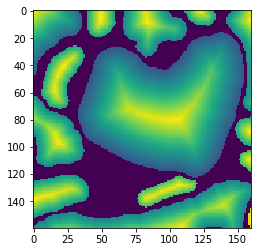

0.0 1.0


In [27]:
def density_map (lbl):
    distance = ndi.distance_transform_edt(lbl)
    idx_list = np.unique (lbl)
    distance = distance + 1.5 * np.std (distance)
    
    max_dist = np.max (distance)
    local_peak_dist_list = []
    ret = np.zeros (lbl.shape, dtype=np.float32)
    print (idx_list.tolist ())
    for i in idx_list:
        if i == 0:
            continue
        local_dist_map = distance * (lbl == i)
        local_peak_dist = np.max (local_dist_map)
        local_peak_dist_list.append (local_peak_dist)
        ret += local_dist_map / local_peak_dist
#     ret = ret / np.max (ret)
    ret = ret
#     ret = np.clip (ret, 0.5, 3.0)
    return ret

processed_map = density_map (tmp_lbl)
plt.imshow (processed_map)
plt.show ()
print (np.min (processed_map), np.max (processed_map))